## Novartis Demo: Distributed Differentially Private PCA in a Secure Environment

This study uses material from : https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8509100

## Imports

In [1]:
import os 
import numpy as np
import pandas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Supporting functions

In [2]:
# function to compute differentially-private second-moment matrix
def dp_pca_ag ( A, N, epsilon = 1.0, delta = 0.1 ):
    sigma = ( 1.0 / ( N * epsilon ) ) * np.sqrt( 2.0 * np.log( 1.25 / delta ) )
    m = A.shape[0]
    temp = np.random.normal( 0, sigma, (m, m))
    temp2 = np.triu(temp)
    temp3 = temp2.transpose()
    temp4 = np.tril(temp3, -1)
    E = temp2 + temp4
    hat_A = A + E
    return hat_A

# function to compute the second-moment matrix of local data
def localPCA(data, epsilon = 0, delta = 0):
    N = data.shape[1] # Number of features 
    C = (1/N) * np.dot(data, data.T)
    if not(epsilon == 0):
        C = dp_pca_ag( C, N, epsilon, delta )
    return C

# function to compute the global second-moment matrix and PCA subspace
def globalPCA(Cs, K):
    C = 0
    S = len(Cs)
    for s in range(S):
        C += Cs[s]
    C = (1/S) * C
    U, S, V = np.linalg.svd(C)
    Uk = U[:, :K]
    return Uk

## Load data

In [3]:
datadir = "~/Novartis/201903_testcase"

In [4]:
iHMPall_MSP_df = pandas.read_csv(
    f"{datadir}/iHMPall_MSP_df.tsv.gz",
    index_col=[0,1], 
    sep = "\t")

iHMPall_metadata_df = pandas.read_csv(
    f"{datadir}/iHMPall_metadata_df.tsv.gz",
    index_col=0,
    sep = "\t")

iHMPall_norm_df = pandas.read_csv(
    f"{datadir}/iHMPall_norm_df.tsv.gz",
    index_col=0,
    sep = "\t")

## Subset relevant samples per Hostipals per Diagnosis 

In [5]:
i_CD_baseline = iHMPall_metadata_df\
    .loc[iHMPall_metadata_df["diagnosis"] == "CD", \
         ["study|subset","participantID", "diagnosis", "visit_num"]]\
            .reset_index()\
            .dropna(axis="index", how="any")["index"].tolist()

i_UC_baseline = iHMPall_metadata_df\
    .loc[iHMPall_metadata_df["diagnosis"] == "UC", \
         ["study|subset","participantID", "diagnosis", "visit_num"]]\
        .reset_index()\
        .dropna(axis="index", how="any")["index"].tolist()

i_nonIBD_baseline = iHMPall_metadata_df\
    .loc[iHMPall_metadata_df["diagnosis"] == "nonIBD",\
        ["study|subset","participantID", "diagnosis", "visit_num"]]\
        .reset_index()\
        .dropna(axis="index", how="any")["index"].tolist()

## Distributed PCA 

In [6]:
#Selecting shared genomic data + normalization 
##CD
iHMPall_MSP_CD = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_CD_baseline]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_CD_baseline].\
           iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

##UC 
iHMPall_MSP_UC = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_UC_baseline]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_UC_baseline].\
           iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

##nonIBD 
iHMPall_MSP_nonIBD = iHMPall_MSP_df\
    .loc[iHMPall_MSP_df.index.get_level_values('module_name') == "core", i_nonIBD_baseline]\
    .apply(lambda s: s / iHMPall_norm_df.loc[:, i_nonIBD_baseline].\
           iloc[0,:].values, axis=1).reset_index(level=1, drop=True)

## Sub-Enclave 1

In [7]:
data_CD = np.nan_to_num(iHMPall_MSP_CD.dropna(axis=1, how="any").values)[0:500]
X_CD = localPCA(data_CD, epsilon = 0.5, delta = 0.00001)

data_UC = np.nan_to_num(iHMPall_MSP_UC.dropna(axis=1, how="any").values)[0:500]
X_UC = localPCA(data_UC, epsilon = 0.5, delta = 0.00001)

data_nonIBD = np.nan_to_num(iHMPall_MSP_nonIBD.dropna(axis=1, how="all").values)[0:500]
X_nonIBD = localPCA(data_nonIBD, epsilon = 0.5, delta = 0.00001)

## Central Dapp with 3 principal components kept

In [8]:
CD_ans = globalPCA([X_CD], K = 3)
UC_ans = globalPCA([X_UC] ,K = 3)
nonIBD_ans = globalPCA([X_nonIBD], K = 3) 

In [9]:
d={"PC1_CD":CD_ans.T[0] ,"PC2_CD":CD_ans.T[1],\
   "PC1_UC":UC_ans.T[0] ,"PC2_UC":UC_ans.T[1],\
   "PC1_nonIBD":nonIBD_ans.T[0] ,"PC2_nonIBD":nonIBD_ans.T[1]}
df_PC = pandas.DataFrame(d)

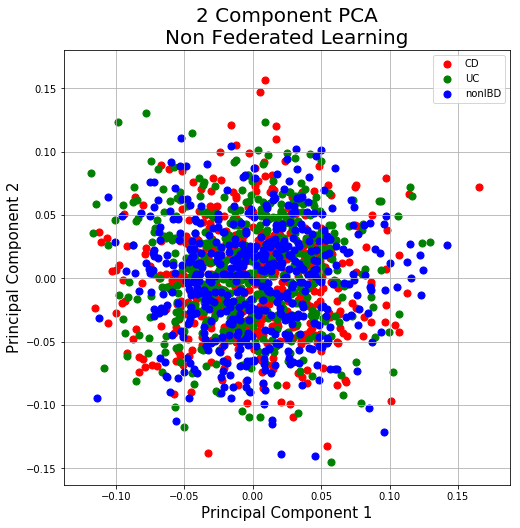

In [10]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA' + "\n" + "Non Federated Learning", fontsize = 20)

Diagnosis = ['CD', 'UC', 'nonIBD']
colors = ['r', 'g', 'b']

ax.scatter(df_PC["PC1_CD"]
       , df_PC["PC2_CD"]
       , c = 'r'
       , s = 50)

ax.scatter(df_PC["PC1_UC"]
       , df_PC["PC2_UC"]
       , c = 'g'
       , s = 50)

ax.scatter(df_PC["PC1_nonIBD"]
      , df_PC["PC2_nonIBD"]
      , c = 'b'
      , s = 50)

ax.legend(Diagnosis)
ax.grid()

In [11]:
d_3D={"PC1_CD":CD_ans.T[0] ,"PC2_CD":CD_ans.T[1],"PC3_CD":CD_ans.T[2],
   "PC1_UC":UC_ans.T[0] ,"PC2_UC":UC_ans.T[1],"PC3_UC":UC_ans.T[2],
   "PC1_nonIBD":nonIBD_ans.T[0] ,"PC2_nonIBD":nonIBD_ans.T[1],"PC3_nonIBD":nonIBD_ans.T[2]}
df_PC_3D = pandas.DataFrame(d_3D)

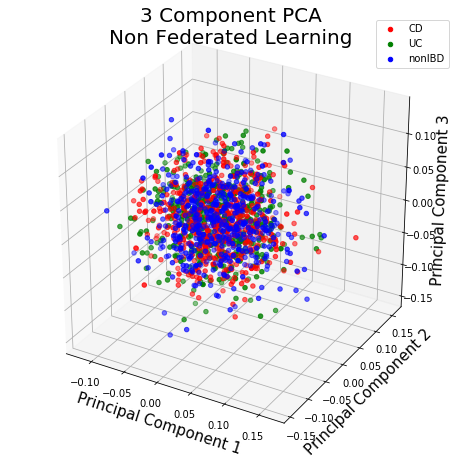

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
Diagnosis = ['CD', 'UC', 'nonIBD']
colors = ['r', 'g', 'b']

ax.scatter(df_PC_3D["PC1_CD"]
       , df_PC_3D["PC2_CD"]
        , df_PC_3D["PC3_CD"]
       , c = 'r')

ax.scatter(df_PC_3D["PC1_UC"]
       ,df_PC_3D["PC2_UC"]
        ,df_PC_3D["PC3_UC"]
       , c = 'g')
ax.scatter(df_PC_3D["PC1_nonIBD"]
      , df_PC_3D["PC2_nonIBD"]
        ,df_PC_3D["PC3_nonIBD"]
      ,c = 'b')

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA' + "\n" + "Non Federated Learning", fontsize = 20)
ax.legend(Diagnosis)
ax.grid()